## Free response Enron dataset

**1.** *Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?*

> The main goal of the project was to create a machine learning model to classify people as possibly related to the fraud that bankrupt the Enron. On the dataset we have data related to payment, stock and email exchange plus metadata like the total number of emails sent by the person of interest (POIs), with these data we can identify people that tried or were linked to the criminal actions which resulted in the fraud. According to the PDF we had two obvious outliers, the "total" and "the travel agency in the park" that aren't possible POIs or have any information to consider, so they were deleted from the dataset.

**2.** *What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.*

> I used all the features available to aggregate information as much as possible, I just removed the emails accounts because for me it don't have significance to my machine learning model.

**3.** *What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?*

> I end up using the `AdaBoostClassifier` because was the best result with the data used, it was compared to `GaussianNB`, `DecisionTreeClassifier` and `svm.SVC`.

**4.** *What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).*

> The parameter tuning is way to boost the machine learning algorithm to have the best perfomance, and it can be archived by testing and treating the results for each banch of parameter test. I just tested the number of estimator until the best results from AdaBoostClassifier, but I could have tried cross-validation to implement  the settings with the best performance. It can also be done automatically by GridSearchCV using different settings combinations to return the best parameters to use.

**5.** *What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?*

> Validation is a way to confirm the results obteined by your model, and it prevets overfitting. My analysis was validate by using cross-validation, dividing the dataset into training data and testing data. I also used the `test.py` script that uses `StratifiedKFolds` that is recommended to use especially when we have a large imbalance in the distribution of the target classes, because it uses stratified sampling to ensure that relative class frequencies is preserved in each train and validation fold. The `test.py` script fit the model and predict with the stratified datases to calculate statistics to validate the model as *accuracy*, *precision*, *recall*, *f1* and *f2 scores*.

**6.** *Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.* 


| algorithm          | accuracy | recall  |
|--------------------|----------|---------|
| AdaBoostClassifier | 0.85573  | 0.34050 |

> An accuracy of 0.85573 means that around 85.6% of the person predicted as POI were right, it isn't high but is good enough for the project threshould. And a recall of 0.34050 means that the algorithm found 34.1% of the POIs present on the dataset.

In [17]:
import sys
sys.path.append("../tools/")

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from feature_format import featureFormat, targetFeatureSplit
from sklearn.feature_selection import SelectPercentile
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from tester import dump_classifier_and_data
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import tester
import pickle

%matplotlib inline

payment_data = ['salary',
                'bonus',
                'long_term_incentive',
                'deferred_income',
                'deferral_payments',
                'loan_advances',
                'other',
                'expenses',                
                'director_fees', 
                'total_payments']

stock_data = ['exercised_stock_options',
              'restricted_stock',
              'restricted_stock_deferred',
              'total_stock_value']

email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']

In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# Take all features except email
features_list = ['poi'] + payment_data + stock_data + email_data 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
### Load dict into pandas df, replace NaN string for np.nan values
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)
df = df[features_list]

### Replace missing values in financial data with zeros
df[payment_data] = df[payment_data].fillna(value=0)
df[stock_data] = df[stock_data].fillna(value=0)
df.head()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
ALLEN PHILLIP K,False,201955.0,4175000.0,304805.0,-3081055.0,2869717.0,0.0,152.0,13868.0,0.0,4484442.0,1729541.0,126027.0,-126027.0,1729541.0,2902.0,2195.0,47.0,65.0,1407.0
BADUM JAMES P,False,0.0,0.0,0.0,0.0,178980.0,0.0,0.0,3486.0,0.0,182466.0,257817.0,0.0,0.0,257817.0,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,False,477.0,0.0,0.0,-5104.0,0.0,0.0,864523.0,56301.0,0.0,916197.0,4046157.0,1757552.0,-560222.0,5243487.0,566.0,29.0,39.0,0.0,465.0
BAXTER JOHN C,False,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,0.0,2660303.0,11200.0,0.0,5634343.0,6680544.0,3942714.0,0.0,10623258.0,NaN,NaN,NaN,NaN,NaN
BAY FRANKLIN R,False,239671.0,400000.0,0.0,-201641.0,260455.0,0.0,69.0,129142.0,0.0,827696.0,0.0,145796.0,-82782.0,63014.0,NaN,NaN,NaN,NaN,NaN


In [3]:
### Task 2: Remove outliers
df.drop(axis=0, labels=['TOTAL','THE TRAVEL AGENCY IN THE PARK'], inplace=True)


In [4]:
### Task 3: Create new feature(s)
# Add the new email features to the dataframe
df['to_poi_average'] = df['from_poi_to_this_person'] / df['to_messages']
df['from_poi_average'] = df['from_this_person_to_poi'] / df['from_messages']
df['shared_poi_average'] = df['shared_receipt_with_poi'] / df['to_messages']
print df[['to_poi_average', 'from_poi_average', 'shared_poi_average']].head()

# Add the new features to the features list
features_list.append('to_poi_average')
features_list.append('from_poi_average')
features_list.append('shared_poi_average')

### Replace any NaN financial data with a 0
df.fillna(value=0, inplace=True)

### Store to my_dataset for easy export below.
my_dataset = df.to_dict(orient='index')

                    to_poi_average  from_poi_average  shared_poi_average
ALLEN PHILLIP K           0.016196          0.029613            0.484838
BADUM JAMES P                  NaN               NaN                 NaN
BANNANTINE JAMES M        0.068905          0.000000            0.821555
BAXTER JOHN C                  NaN               NaN                 NaN
BAY FRANKLIN R                 NaN               NaN                 NaN


number of data points: 3312
number of POIs and non-POIs: 18, 126
number of features used: 23
features with missing values: see plot


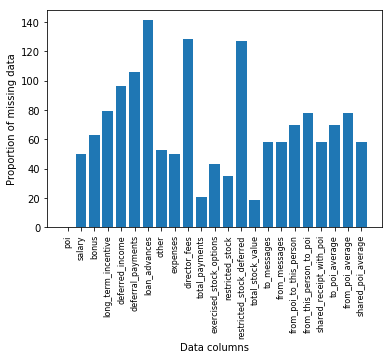

In [5]:
### Return statistics about the dataset
non_poi, poi = df.poi.value_counts()
lines, columns = df.shape[0], df.shape[1]
print 'number of data points: %s' % (lines * columns)
print 'number of POIs and non-POIs: %s, %s' % (poi, non_poi)
print 'number of features used: %s (correct in the end)' % len(features_list)
print 'features with missing values: see plot'
count_nan = []
for label in df.columns:
    miss_val = (df[label] == 0).sum(axis=0)
    if df[label].dtype == 'bool':
        count_nan.append(0)
    else:
        count_nan.append(miss_val)
# Plot missing values distribution by columns
plt.bar(df.columns, count_nan)
plt.xlabel('Data columns', fontsize=10)
plt.ylabel('Proportion of missing data', fontsize=10)
plt.xticks(df.columns, df.columns, rotation=90, fontsize=8)
plt.legend([0.0])
plt.show()

In [12]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Create lists with variable parameters to test
percentile = list(range(1, 100))
min_split = list(range(2, 100))
estimator = list(range(10,100,10))

In [7]:
def fit_grids(grids, features, labels):
    ''' Fit model and print score and best parameter '''
    grids.fit(features, labels)
    print 'Best score: ', grids.best_score_
    print 'Best parameter no: ', grids.best_params_

In [46]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Create pipeline to test feature selection and the algorithms
# DecisionTree
pipeline_dt = Pipeline([('select', SelectPercentile()), ('dt', DecisionTreeClassifier())])
grids_dt = GridSearchCV(pipeline_dt, {
    'select__percentile': percentile, 'dt__min_samples_split': min_split}, cv=5, iid=0, 
    scoring='precision')

# General code to fit and print results
fit_grids(grids_dt, features, labels)

Best score:  0.55
Best parameter no:  {'dt__min_samples_split': 4, 'select__percentile': 31}


In [51]:
print(grids_dt.best_params_['select__percentile'])
print(grids_dt.best_params_['dt__min_samples_split'])

31
4


In [9]:
# GaussianNB
pipeline_gnb = Pipeline([('select', SelectPercentile()), ('gnb', GaussianNB())])
grids_gnb = GridSearchCV(pipeline_gnb, {
    'select__percentile': percentile}, cv=5, iid=0, scoring='precision')

# General code to fit and print results
fit_grids(grids_gnb, features, labels)

Best score:  0.4833333333333333
Best parameter no:  {'select__percentile': 15}


In [10]:
# AdaBoostClassifier
pipeline_ab = Pipeline([('select', SelectPercentile()), ('ab', AdaBoostClassifier())])
grids_ab = GridSearchCV(pipeline_ab, {
    'select__percentile': percentile, 'ab__n_estimators': estimator}, cv=5, iid=0,
    scoring='precision')

# General code to fit and print results
fit_grids(grids_ab, features, labels)

Best score:  0.6444444444444445
Best parameter no:  {'select__percentile': 67, 'ab__n_estimators': 40}


In [28]:
def select_perc(features_train, labels_train, perc):
    ''' Select features and transform the old ones '''
    # Select features with SelectPercentile
    select = SelectPercentile(percentile=perc)
    select.fit(features_train, labels_train)
    # Transform features and labels
    features_train_selected = select.transform(features_train)
    features_test_selected = select.transform(features_test)
    return select, features_train_selected, features_test_selected
    
# Example starting point. Try investigating other evaluation techniques!
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

def fit_and_stat_model(clf, features_train, labels_train, features_test, labels_test):
    ''' Fit model and return accuracy, precision and recall '''
    clf.fit(features_train_selected, labels_train)
    pred = clf.predict(features_test_selected)
    acc = accuracy_score(labels_test, pred)
    prec = precision_score(labels_test, pred)
    rec = recall_score(labels_test, pred)
    f1 = 2 * (prec * rec) / (prec + rec)
    
    print 'Accuracy: ', acc
    print 'Precision: ', prec
    print 'Recall: ', rec
    print 'F1-score: ', f1

In [29]:
# Select features to run Decision Tree model
select, features_train_selected, features_test_selected = select_perc(features_train, labels_train, 24)

clf = DecisionTreeClassifier(min_samples_split=2)
clf.fit(features_train_selected, labels_train)
pred = clf.predict(features_test_selected)

# Return stats
fit_and_stat_model(clf, features_train, labels_train, features_test, labels_test)

# Return cross validation
print(cross_val_score(clf, features, labels, scoring='recall', cv=10).mean())

Accuracy:  0.7906976744186046
Precision:  0.16666666666666666
Recall:  0.2
F1-score:  0.1818181818181818
0.3


In [45]:
# List of booleans from features selected
features_nopoi = np.array(features_list[1:])
mask = select.get_support()
print 'Len of mask: ', len(mask)
print 'Type of mask: ', type(mask)
print 'Len of features list: ', len(features_nopoi)
print 'Type of features list: ', type(features_nopoi)
print(mask)
print(features_nopoi)
print()
print(features_nopoi[mask])
print(len(features_nopoi[mask]))
print(sum(mask))

Len of mask:  22
Type of mask:  <type 'numpy.ndarray'>
Len of features list:  22
Type of features list:  <type 'numpy.ndarray'>
[ True  True False False False False False False False False False False
 False  True False False False False  True False  True  True]
['salary' 'bonus' 'long_term_incentive' 'deferred_income'
 'deferral_payments' 'loan_advances' 'other' 'expenses' 'director_fees'
 'total_payments' 'exercised_stock_options' 'restricted_stock'
 'restricted_stock_deferred' 'total_stock_value' 'to_messages'
 'from_messages' 'from_poi_to_this_person' 'from_this_person_to_poi'
 'shared_receipt_with_poi' 'to_poi_average' 'from_poi_average'
 'shared_poi_average']
()
['salary' 'bonus' 'total_stock_value' 'shared_receipt_with_poi'
 'from_poi_average' 'shared_poi_average']
6
6
